# Herbarium Contrastive Learning EVALUATION Notebook
Marko Kadic, TU Wien

In this notebook I will apply contrastive learning, more specifically SimCLR to the Herbarium Challenge 2022 Dataset that can be found here:
https://www.kaggle.com/competitions/herbarium-2022-fgvc9/overview/cvpr-2022

Firstly I will embed the images using the SimCLR algorithm and then I will train a linear classifier
over these embeddings in order to predict the genme classes of hte plants in order to have a quantitative
evaluation of using this deep learning approach on the Herbarium dataset.

The tool should help them explore the vast collection of plants of the Vienna Natural History Museum (NHM).

**0. Installing Dependencies**

In [2]:
import sklearn
import scipy
#import skimage
import pandas
import numpy as np
from PIL import Image
import bokeh
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models

## Torchvision
import torchvision
from torchvision import transforms

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

from tensorboard.plugins import projector

import cv2
import pathlib
import os
import datetime
#import tensorflow as tf

from os import listdir, walk
from os.path import isfile, join

from tensorboardX import SummaryWriter

/tmp/ipykernel_742989/1609014514.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [1]:
import wandb
import random

ModuleNotFoundError: No module named 'wandb'

In [2]:
%pip install tensorboardX

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


**1. Dataset**
Data loading and Data preparation

<class 'numpy.ndarray'>
(1000, 666, 3)


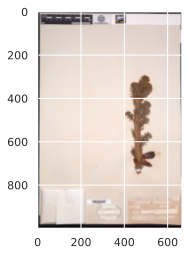

In [3]:
data_path_train = "/gpfs/data/fs71186/kadic/train_images"
data_path_test = "/gpfs/data/fs71186/kadic/test_images"
# Convert
img = cv2.imread(data_path_train + "/000/00/00000__001.jpg")
print(type(img))

print(img.shape)

RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(RGB_img)
  
# display that image
plt.show()

In [4]:
from os import listdir, walk
from os.path import isfile, join

train_image_files = [join(dirpath,f) for (dirpath, dirnames, filenames) in walk(data_path_train) for f in filenames] 

print(len(train_image_files))

679989


In [5]:
test_image_files = [join(dirpath,f) for (dirpath, dirnames, filenames) in walk(data_path_test) for f in filenames] 

print(len(test_image_files))

210407


**1.1. GPU, MACRO SETUP**

In [6]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = data_path_train
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/contrastive_models"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

[rank: 0] Global seed set to 42


Device: cuda:0
Number of workers: 256


In [7]:
class ImageDataset(Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    

    def __getitem__(self, index):
        image_path = self.paths[index]
        image_l = Image.open(image_path)
        image = image_l.convert('RGB')
        
        if self.transform:
            image_tensor = self.transform(image)
            
        return image_tensor


#dataset = ImageDataset(image_paths, transform)
    
#train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=1, shuffle=True)

**3. Contrastive Learning**

3.1. Augmenting the images

In [8]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [9]:

contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          #transforms.RandomApply([
                                          #    transforms.ColorJitter(brightness=0.5,
                                          #                           contrast=0.5,
                                          #                           saturation=0.5,
                                          #                           hue=0.1)
                                          #], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          #transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

In [14]:

# Load dataset subset
dataset_train = ImageDataset(train_image_files, 
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))
#sub_train_loader = DataLoader(dataset_sub, batch_size = 100, num_workers = 1, shuffle = True)

#dataset_sub = SimpleImageDataset(sub_image_paths)

print(dataset_train[0][0].shape)

torch.Size([3, 96, 96])


[rank: 0] Global seed set to 42


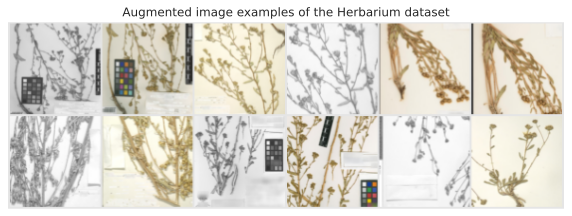

In [15]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in dataset_train[idx]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the Herbarium dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### 3.2. Contrastive Learning with SimCLR ###

In [16]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs1, imgs2 = batch
        imgs = torch.cat((imgs1,imgs2), dim=0)
        
        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())
        
        wandb.log({"val_acc_top5": (sim_argsort < 5).float().mean(), "loss": nll})
        
        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    #def validation_step(self, batch, batch_idx):
    #    self.info_nce_loss(batch, mode='val')

Training

In [17]:
def train_simclr(batch_size, max_epochs=2, **kwargs):
    log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    trainer = pl.Trainer(default_root_dir=CHECKPOINT_PATH +  "/SimCLR_VAL",
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True,  mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = CHECKPOINT_PATH +  '/SimCLR_Eval_2_Validated.ckpt'
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = DataLoader(dataset_train, batch_size = batch_size, shuffle = True, drop_last = True,num_workers = NUM_WORKERS)
        val_loader = DataLoader(dataset_val, batch_size = batch_size, shuffle = True, num_workers = NUM_WORKERS)
        
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        trainer.save_checkpoint(pretrained_filename)
        
    return model

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="contrastive-NHM",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 5e-4,
    "architecture": "SimCLR",
    "dataset": "Herbarium-2022",
    "epochs": 100,
    }
)

# RUN THE TRAINING 
simclr_model = train_simclr(batch_size=256,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=500)

wandb.finish()

In [ ]:
!nvidia-smi

In [ ]:
!pip3 install ipywidgets==7.7.5

## 4. Acquiring Feature Vectors from Model ##

In [9]:
pretrained_filename =  './saved_models/SimCLR.ckpt'

view_transforms = transforms.Compose([ transforms.Resize((180, 114)),
                                       transforms.ToTensor()
                                    ])

dataset_full_nocut = ImageDataset(all_image_files, 
                       transform=ContrastiveTransformations(view_transforms, n_views=1)) 

#print(len(datset_full_nocut))


In [10]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, shuffle=False, drop_last=False)
    feats, imgs = [], []
    for batch_imgs in tqdm(data_loader):
        #print(batch_imgs[0].size())
        batch_imgs = batch_imgs[0].to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())

    return feats

In [11]:
simclr_model = SimCLR.load_from_checkpoint(pretrained_filename)
print(type(simclr_model))
train_feats_simclr = prepare_data_features(simclr_model, dataset_full_nocut)

<class '__main__.SimCLR'>


  0%|          | 0/18 [00:00<?, ?it/s]

In [12]:
print(train_feats_simclr[0].size())

torch.Size([64, 512])


In [13]:
features_tensor = torch.cat(train_feats_simclr, 0)
print(features_tensor.size())
torch.save(train_feats_simclr, "./features_tensor.tsv")

LOG_DIR = "/logs"

torch.Size([1103, 512])


In [14]:
images_vis_ts =[]

view_transforms_img = transforms.Compose([ 
                                       transforms.Resize((10,10)),
                                       transforms.ToTensor()
                                    ])

dataset_full_nocut = ImageDataset(all_image_files, 
                       transform=ContrastiveTransformations(view_transforms_img, n_views=1)) 

for btch in DataLoader(dataset_full_nocut, batch_size=64, shuffle=False, drop_last=False):
    # convert the tensor to PIL image using above transform
    for i in range(0,len(btch)):
        images_vis_ts.append(btch[i])
    

In [15]:
print(len(images_vis_ts))

images_vis_ts = torch.cat(images_vis_ts,0)
print(len(images_vis_ts))

18
1103


In [3]:
%reload_ext tensorboard
%tensorboard --logdir=../saved_models/contrastive_learning/SIM_CLR_VAL_3/lightning_logs/